In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
industry = ['MMM','GE','CAT','SIEGY','HON']


In [3]:
df = yahoo.download(industry,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  5 of 5 completed


SIEGY    1.450689
CAT      1.220103
MMM      1.050233
HON      0.984949
GE       0.790838
dtype: float64

In [4]:
df

,CAT,GE,HON,MMM,SIEGY
Datetime,,,,,
2019-08-15 09:30:00-04:00,114.719803,8.4088,162.779999,158.145798,47.150002
2019-08-15 10:30:00-04:00,115.050003,8.0101,162.802094,158.350006,47.169998
2019-08-15 11:30:00-04:00,115.029999,8.0301,162.820007,158.014999,47.174999
2019-08-15 12:30:00-04:00,114.820000,7.9000,162.339996,157.179993,47.139999
2019-08-15 13:30:00-04:00,114.839996,7.9900,162.110001,157.315002,47.090000
...,...,...,...,...,...
2020-08-14 11:30:00-04:00,140.740005,6.6750,160.311600,165.520004,68.625000
2020-08-14 12:30:00-04:00,140.419998,6.6850,160.002304,165.975006,68.640503
2020-08-14 13:30:00-04:00,140.160004,6.6901,160.520004,166.220001,68.570000


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = len(df.index)
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

SIEGY    0.3
MMM      0.3
HON      0.3
CAT      0.3
GE      -0.2
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


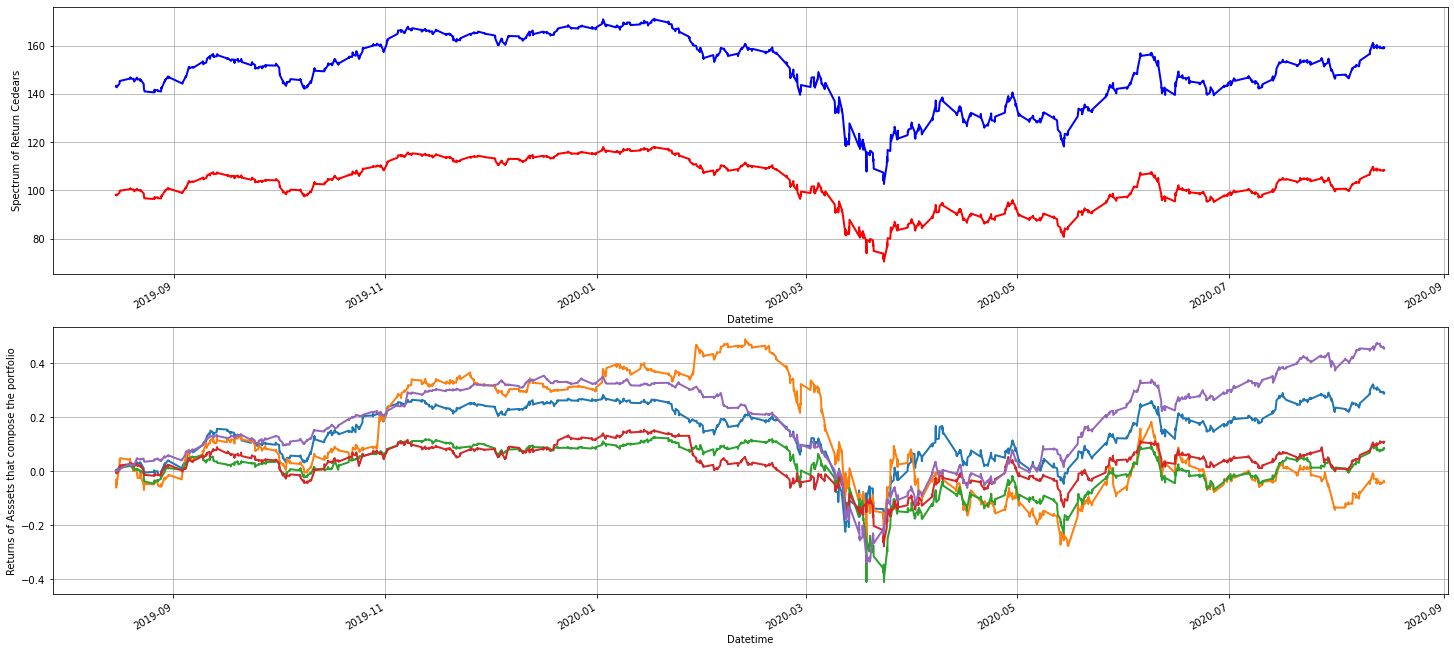

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-15 09:30:00-04:00    143.156920
 2019-08-15 10:30:00-04:00    143.409610
 2019-08-15 11:30:00-04:00    143.305981
 2019-08-15 12:30:00-04:00    142.863996
 2019-08-15 13:30:00-04:00    142.808500
                                 ...    
 2020-08-14 11:30:00-04:00    159.223983
 2020-08-14 12:30:00-04:00    159.174343
 2020-08-14 13:30:00-04:00    159.302983
 2020-08-14 14:30:00-04:00    158.970498
 2020-08-14 15:30:00-04:00    159.107000
 Length: 1767, dtype: float64,
 Datetime
 2019-08-15 09:30:00-04:00     98.240880
 2019-08-15 10:30:00-04:00     98.276440
 2019-08-15 11:30:00-04:00     98.214021
 2019-08-15 12:30:00-04:00     97.875998
 2019-08-15 13:30:00-04:00     97.869000
                                 ...    
 2020-08-14 11:30:00-04:00    108.374322
 2020-08-14 12:30:00-04:00    108.344562
 2020-08-14 13:30:00-04:00    108.432022
 2020-08-14 14:30:00-04:00    108.201999
 2020-08-14 15:30:00-04:00    108.288000
 Length: 1767, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

SIEGY    0.3
MMM      0.3
HON      0.3
CAT      0.3
GE      -0.2
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-15 09:30:00-04:00    143.156920
2019-08-15 10:30:00-04:00    143.409610
2019-08-15 11:30:00-04:00    143.305981
2019-08-15 12:30:00-04:00    142.863996
2019-08-15 13:30:00-04:00    142.808500
                                ...    
2020-08-14 11:30:00-04:00    159.223983
2020-08-14 12:30:00-04:00    159.174343
2020-08-14 13:30:00-04:00    159.302983
2020-08-14 14:30:00-04:00    158.970498
2020-08-14 15:30:00-04:00    159.107000
Length: 1767, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
CAT,0.2,0.726074,0.010075,0.021945,0.113086
GE,0.2,0.703674,0.014843,0.031334,0.113086
HON,0.2,0.720002,0.010622,0.022943,0.113086
MMM,0.2,0.695945,0.008193,0.017105,0.113086
SIEGY,0.2,0.685447,0.009609,0.019759,0.113086


In [15]:
poe, fullstress

(CAT     -10.498796
 GE       -9.935270
 HON     -10.258357
 MMM      -9.542160
 SIEGY   -10.175222
 dtype: float64,
 -1.1413336645443688)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-15 09:30:00-04:00     98.240880
2019-08-15 10:30:00-04:00     98.276440
2019-08-15 11:30:00-04:00     98.214021
2019-08-15 12:30:00-04:00     97.875998
2019-08-15 13:30:00-04:00     97.869000
                                ...    
2020-08-14 11:30:00-04:00    108.374322
2020-08-14 12:30:00-04:00    108.344562
2020-08-14 13:30:00-04:00    108.432022
2020-08-14 14:30:00-04:00    108.201999
2020-08-14 15:30:00-04:00    108.288000
Length: 1767, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
CAT,0.000282,-0.019372,0.014536,0.010554,0.038315,0.007663,0.036927,0.207518
GE,0.000409,-0.019372,0.021125,0.014865,0.052302,0.010460,0.036927,0.283273
HON,0.000294,-0.019372,0.015161,0.010916,0.039296,0.007859,0.036927,0.212834
MMM,0.000206,-0.019372,0.010616,0.007388,0.025710,0.005142,0.036927,0.139248
SIEGY,0.000239,-0.019372,0.012349,0.008465,0.029011,0.005802,0.036927,0.157128


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
CAT,0.2,0.207518,0.3,0.041504,0.062255,0.020752,0.5,0.45,2.0,0.225
GE,0.2,0.283273,-0.2,0.056655,-0.056655,-0.113309,-2.0,0.20,2.0,0.100
HON,0.2,0.212834,0.3,0.042567,0.063850,0.021283,0.5,0.45,2.0,0.225
MMM,0.2,0.139248,0.3,0.027850,0.041774,0.013925,0.5,0.45,2.0,0.225
SIEGY,0.2,0.157128,0.3,0.031426,0.047138,0.015713,0.5,0.45,2.0,0.225


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

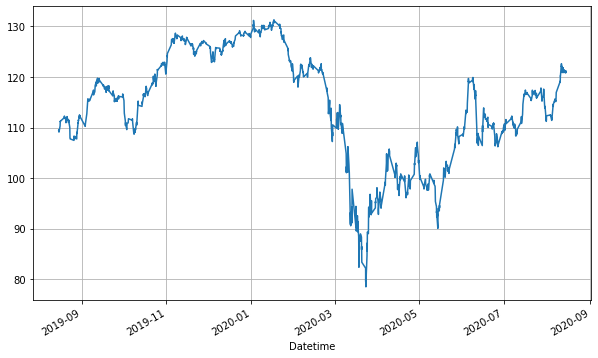

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
propuesta

Datetime
2019-08-15 09:30:00-04:00    109.469890
2019-08-15 10:30:00-04:00    109.559733
2019-08-15 11:30:00-04:00    109.487011
2019-08-15 12:30:00-04:00    109.122997
2019-08-15 13:30:00-04:00    109.103875
                                ...    
2020-08-14 11:30:00-04:00    121.086737
2020-08-14 12:30:00-04:00    121.052008
2020-08-14 13:30:00-04:00    121.149762
2020-08-14 14:30:00-04:00    120.894124
2020-08-14 15:30:00-04:00    120.992750
Length: 1767, dtype: float64

In [23]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

SIEGY    0.225
MMM      0.225
HON      0.225
CAT      0.225
GE       0.100
Name: MinCVaR, dtype: float64